<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Batch and Recursive Bayesian Estimation

## 3.0 Imports

In [119]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

## 3.1 Batch Linear Regression

First, we generate some data that approximately replicates Figure 3.1.

In [101]:
# Generate grid
X = jnp.linspace(0.0, 1.0, 100)

# Define linear regression model
def lr_model(key, x, theta, var):
    epsilon = jr.normal(key)*var
    return theta[1] * x + theta[0] + epsilon
lr_model_vmap = jax.vmap(lr_model, in_axes=(0, 0, None, None), out_axes=0)

# True parameter values
theta = jnp.array([1, 0.5])

# True signal
Y_tr = theta[1] * X + theta[0]

# Generate dataset (var = 0.1)
var = 0.1
keys = jr.split(jr.PRNGKey(42), X.shape[0])
Y = lr_model_vmap(keys, X, theta, var)

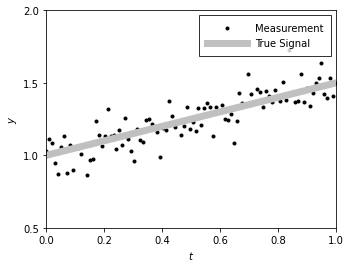

In [102]:
# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurement')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 1); plt.ylim(0.5, 2)
plt.yticks(jnp.arange(0.5, 2.1, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Now we apply the batch solution, given by equation (3.4):
\begin{align*}
    \textbf{m}_T &= \left[ \textbf{P}_0^{-1} + \frac{1}{\sigma^2} \textbf{H}^T \textbf{H} \right]^{-1} \left[ \frac{1}{\sigma^2} \textbf{H}^T \textbf{y} + \textbf{P}_0^{-1} \textbf{m}_0 \right] \\
\textbf{P}_T &= \left[ \textbf{P}_0^{-1} + \frac{1}{\sigma^2} \textbf{H}^T \textbf{H} \right]^{-1}
\end{align*}
where our we arbitrarily set our prior distribution to:
\begin{align*}
    p(\theta) &= \mathcal{N}(\theta \mid \textbf{m}_0, \textbf{P}_0) = \mathcal{N}(\theta \mid (0, 0)^T, \mathcal{I})
\end{align*}

In [113]:
# Parameter update model
def update_params(m_prior, P_prior, X, Y, meas_var):
    H = jnp.vstack(([1, x] for x in X))
    P_post = jnp.linalg.inv(jnp.linalg.inv(P_0) + H.T @ H / meas_var)
    m_post = P_post @ (H.T @ Y / meas_var + jnp.linalg.inv(P_0) @ m_0)
    return m_post, P_post 

In [128]:
# Prior parameters
m_0 = jnp.array([0,0], dtype=jnp.float32)
P_0 = jnp.eye(2)

# Posterior parameters
m_T, P_T = update_params(m_0, P_0, X, Y, var)

print('True theta value = ', theta)
print('Posterior theta mean = ', m_T)

True theta value =  [1.  0.5]
Posterior theta mean =  [0.979979   0.53430796]


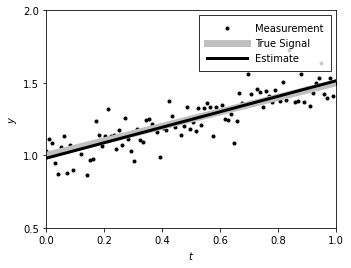

In [129]:
# Posterior estimation
Y_post = m_T[1] * X + m_T[0]

# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurement')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.plot(X, Y_post, color='k', linewidth=3, label="Estimate")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 1); plt.ylim(0.5, 2)
plt.yticks(jnp.arange(0.5, 2.1, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

## 3.2 Recursive Linear Regression

We use equation (3.7) to replicate Figure 3.3.

In [215]:
def recursive_lin_reg(m_0, P_0, obs_var, X, Y):
    def _step(carry, t):
        m_k, P_k = carry
        H_k = jnp.array([[1, X[t]]])

        # Compute params after single update
        P_post = jnp.linalg.inv(jnp.linalg.inv(P_k) + H_k.T @ H_k / obs_var)
        m_post = P_post @ (H_k * Y[t] / obs_var + 
                           jnp.linalg.inv(P_k) @ m_k).reshape(2,)

        return (m_post, P_post), (m_post, P_post)

    num_timesteps = len(Y)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

In [216]:
# Batch data
theta1_batch = jnp.ones(X.shape) * m_T[0]
theta2_batch = jnp.ones(X.shape) * m_T[1]

# Recursive data
ms, Ps = recursive_lin_reg(m_0, P_0, var, X, Y)
theta1_recursive = ms[:,0]
theta2_recursive = ms[:,1]

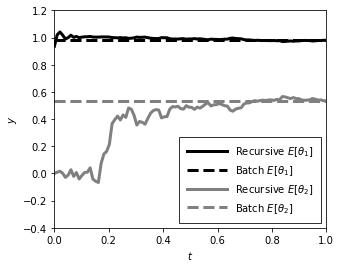

In [217]:
# Batch data
theta1_batch = jnp.ones(X.shape) * m_T[0]
theta2_batch = jnp.ones(X.shape) * m_T[1]

# Plot the generated data
plt.figure()
plt.plot(X, theta1_recursive, 'k', linewidth=3, label=r"Recursive $E[\theta_1]$")
plt.plot(X, theta1_batch, 'k--', linewidth=3, label=r"Batch $E[\theta_1]$")
plt.plot(X, theta2_recursive, color='gray', linewidth=3, label=r"Recursive $E[\theta_2]$")
plt.plot(X, theta2_batch, '--', color='gray', linewidth=3, label=r"Batch $E[\theta_2]$")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 1); plt.ylim(-0.4, 1.2)
plt.yticks(jnp.arange(-0.4, 1.3, 0.2))
plt.gca().set_aspect(0.5)
plt.legend(loc=4, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()